# **Tugas Analisis PySpark (case vehicle price prediction dataset)**

## **Anggota Kelompok:**
1.   Subkhan Masudi (5027221044)
2.   Nur Azka Radiansyah (5027221064)

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, FloatType
from pyspark.sql import Row
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Vehicle Price Prediction") \
    .getOrCreate()

# Load data
df = spark.read.csv('vehicles.csv', header=True, inferSchema=True)

# Display shape and columns
print(f"DataFrame shape: {df.count()} rows and {len(df.columns)} columns")
print(df.columns)

DataFrame shape: 441802 rows and 26 columns
['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'lat', 'long', 'posting_date']


1. **Menginisialisasi Spark Session:**
   ```python
   spark = SparkSession.builder \
       .appName("Vehicle Price Prediction") \
       .getOrCreate()
   ```
   Bagian ini menginisialisasi sebuah *Spark session* menggunakan PySpark, yaitu sebuah antarmuka Python untuk *Apache Spark*. Metode ini dimulai dengan membuat sebuah objek `SparkSession` dengan nama aplikasi **"Vehicle Price Prediction"**. `getOrCreate()` akan membuat sesi baru jika belum ada, atau menggunakan sesi yang sudah ada. *Spark session* ini dibutuhkan untuk berinteraksi dengan *Spark* dalam analisis data.

2. **Memuat data:**
   ```python
   df = spark.read.csv('vehicles.csv', header=True, inferSchema=True)
   ```
   Di sini, dataset **`vehicles.csv`** dimuat ke dalam sebuah DataFrame PySpark menggunakan metode `spark.read.csv()`. Argumen:
   - `header=True` berarti file CSV memiliki baris pertama sebagai header (nama kolom).
   - `inferSchema=True` memungkinkan PySpark untuk secara otomatis mendeteksi tipe data dari setiap kolom berdasarkan isinya.

3. **Menampilkan ukuran dan kolom DataFrame:**
   ```python
   print(f"DataFrame shape: {df.count()} rows and {len(df.columns)} columns")
   print(df.columns)
   ```
   - `df.count()` menghitung jumlah baris dalam DataFrame.
   - `len(df.columns)` menghitung jumlah kolom dalam DataFrame.
   - `df.columns` menampilkan nama-nama kolom yang ada di DataFrame.

Hasil akhirnya adalah informasi jumlah baris, jumlah kolom, serta daftar nama kolom dari dataset yang dimuat.

In [3]:
# Drop unnecessary columns
df = df.drop('id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date')

# Check for null values
null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+-----------+------+
|region|price|year|manufacturer|model|condition|cylinders| fuel|odometer|title_status|transmission| drive|  size|  type|paint_color|county|
+------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+-----------+------+
|  6901| 6446|7890|       28937|17506|   187143|   190798|16344|   17801|       21618|       15932|144178|319997|106892|     143839|382283|
+------+-----+----+------------+-----+---------+---------+-----+--------+------------+------------+------+------+------+-----------+------+



In [4]:
# Dropping columns with more than 25% null values
threshold = df.count() * 0.25
df = df.drop(*[c for c in df.columns if df.filter(col(c).isNull()).count() > threshold])

# Drop specific categorical columns
df = df.drop('region', 'manufacturer', 'model', 'fuel')

# Drop rows with null values in specific columns
for column in ['odometer', 'type', 'title_status', 'year', 'transmission']:
    df = df.filter(df[column].isNotNull())

1. **Menghapus kolom yang tidak diperlukan:**
   ```python
   df = df.drop('id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'state', 'lat', 'long', 'posting_date')
   ```
   Bagian ini menggunakan metode `drop()` untuk menghapus kolom yang tidak diperlukan dari DataFrame. Kolom-kolom seperti `'id'`, `'url'`, `'region_url'`, `'VIN'`, `'image_url'`, `'description'`, `'state'`, `'lat'`, `'long'`, dan `'posting_date'` dihapus karena dianggap tidak relevan untuk analisis atau model prediksi harga kendaraan.

2. **Memeriksa nilai *null* dalam kolom:**
   ```python
   null_counts = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
   null_counts.show()
   ```
   Bagian ini memeriksa apakah ada nilai *null* atau *NaN* (Not a Number) di dalam setiap kolom DataFrame.
   
   - `isnan(c)` memeriksa apakah nilai di kolom `c` adalah NaN.
   - `col(c).isNull()` memeriksa apakah nilai di kolom `c` adalah *null*.
   - `when(isnan(c) | col(c).isNull(), c)` mengembalikan kolom tersebut hanya jika nilainya *null* atau *NaN*.
   - `count()` menghitung jumlah nilai *null*/*NaN* dalam setiap kolom.
   - `alias(c)` memberikan nama alias untuk hasil hitungannya sesuai nama kolom.

   Hasilnya akan ditampilkan menggunakan `.show()`, yang menampilkan jumlah nilai *null* atau *NaN* dalam setiap kolom. Ini penting untuk memeriksa kualitas data sebelum melakukan analisis atau modeling lebih lanjut.

In [5]:
# Convert 'odometer' to a numeric type (IntegerType)
df = df.withColumn('odometer', when(col('odometer').cast(IntegerType()).isNotNull(), col('odometer').cast(IntegerType())).otherwise(None))

# Dropping rows with null values in 'odometer' after conversion
df = df.filter(df['odometer'].isNotNull())

# Convert 'price' to a numeric type (FloatType or IntegerType)
df = df.withColumn('price', when(col('price').cast(FloatType()).isNotNull(), col('price').cast(FloatType())).otherwise(None))

# Dropping rows with null values in 'price' after conversion
df = df.filter(df['price'].isNotNull())

# Change the data type of 'year'
df = df.withColumn('year', df['year'].cast(IntegerType()))

# Drop rows with low prices
df = df.filter((df['price'] > 100))

# Remove outliers
df = df.filter(df['price'] < 249999)

1. **Menghapus kolom dengan lebih dari 25% nilai *null*:**
   ```python
   threshold = df.count() * 0.25
   df = df.drop(*[c for c in df.columns if df.filter(col(c).isNull()).count() > threshold])
   ```
   - `df.count() * 0.25` menghitung batas 25% dari jumlah total baris dalam DataFrame.
   - `df.filter(col(c).isNull()).count()` menghitung jumlah nilai *null* dalam setiap kolom `c`.
   - Jika jumlah *null* dalam kolom tersebut lebih besar dari batas (threshold), kolom tersebut akan dihapus dengan menggunakan `drop()`.
   - `*[]` menyebarkan daftar kolom yang ingin dihapus sebagai argumen untuk metode `drop()`.

   **Tujuan:** Menghapus kolom yang terlalu banyak memiliki nilai *null* (> 25%) karena kolom tersebut mungkin tidak memberikan informasi yang cukup untuk analisis.

2. **Menghapus kolom kategorikal tertentu:**
   ```python
   df = df.drop('region', 'manufacturer', 'model', 'fuel')
   ```
   Kolom-kolom seperti `'region'`, `'manufacturer'`, `'model'`, dan `'fuel'` dihapus secara manual karena mungkin dianggap tidak relevan dalam analisis atau prediksi harga kendaraan. Mungkin kolom ini redundant atau tidak diperlukan untuk prediksi.

3. **Menghapus baris dengan nilai *null* di kolom spesifik:**
   ```python
   for column in ['odometer', 'type', 'title_status', 'year', 'transmission']:
       df = df.filter(df[column].isNotNull())
   ```
   - `df.filter(df[column].isNotNull())` akan menyaring DataFrame dan hanya menyimpan baris yang **tidak memiliki nilai *null*** pada kolom yang ditentukan.
   - Loop ini diterapkan pada kolom `'odometer'`, `'type'`, `'title_status'`, `'year'`, dan `'transmission'`, untuk memastikan baris yang memiliki *null* pada kolom tersebut dihapus.

   **Tujuan:** Menghilangkan baris yang tidak memiliki data lengkap pada kolom penting seperti odometer (kilometer), jenis kendaraan, status sertifikat, tahun pembuatan, dan jenis transmisi, sehingga meningkatkan kualitas data untuk analisis lebih lanjut.

In [6]:
# Encoding the year categories
df = df.withColumn('year', when(col('year') <= 1945, 'ancient')
                   .when((col('year') > 1945) & (col('year') <= 1980), 'old')
                   .when((col('year') > 1980) & (col('year') <= 2015), 'middle')
                   .otherwise('new'))

# One-hot encoding
year_indexer = StringIndexer(inputCol='year', outputCol='year_index')
title_status_indexer = StringIndexer(inputCol='title_status', outputCol='title_status_index')
transmission_indexer = StringIndexer(inputCol='transmission', outputCol='transmission_index')
type_indexer = StringIndexer(inputCol='type', outputCol='type_index')

encoder = OneHotEncoder(inputCols=['year_index', 'title_status_index', 'transmission_index', 'type_index'], 
                         outputCols=['year_ohe', 'title_status_ohe', 'transmission_ohe', 'type_ohe'])

1. **Encoding kategori tahun:**
   ```python
   df = df.withColumn('year', when(col('year') <= 1945, 'ancient')
                      .when((col('year') > 1945) & (col('year') <= 1980), 'old')
                      .when((col('year') > 1980) & (col('year') <= 2015), 'middle')
                      .otherwise('new'))
   ```
   - `withColumn()` digunakan untuk membuat atau mengganti kolom yang ada.
   - Kondisi `when()` digunakan untuk mengelompokkan nilai pada kolom `year` ke dalam kategori berbasis tahun:
     - **'ancient'** untuk tahun yang lebih kecil atau sama dengan 1945.
     - **'old'** untuk tahun antara 1945 hingga 1980.
     - **'middle'** untuk tahun antara 1980 hingga 2015.
     - **'new'** untuk tahun yang lebih baru dari 2015.
   
   **Tujuan:** Mengelompokkan kendaraan berdasarkan rentang tahun ke dalam beberapa kategori untuk memudahkan analisis atau modeling.

2. **String Indexing:**
   - StringIndexer digunakan untuk mengonversi kolom dengan nilai kategori berbentuk string menjadi nilai numerik indeks.

   ```python
   year_indexer = StringIndexer(inputCol='year', outputCol='year_index')
   title_status_indexer = StringIndexer(inputCol='title_status', outputCol='title_status_index')
   transmission_indexer = StringIndexer(inputCol='transmission', outputCol='transmission_index')
   type_indexer = StringIndexer(inputCol='type', outputCol='type_index')
   ```
   - **`year_indexer`**: Mengonversi kolom `year` (yang sekarang mengandung kategori `'ancient'`, `'old'`, `'middle'`, dan `'new'`) menjadi kolom numerik baru bernama `year_index`.
   - **`title_status_indexer`**: Mengonversi kolom `title_status` (status sertifikat kendaraan) ke indeks numerik.
   - **`transmission_indexer`**: Mengonversi kolom `transmission` (jenis transmisi) menjadi nilai numerik.
   - **`type_indexer`**: Mengonversi kolom `type` (jenis kendaraan) menjadi nilai numerik.

   **Tujuan:** Sebelum melakukan proses *one-hot encoding* atau analisis lainnya, data kategori perlu diubah ke bentuk numerik dengan menggunakan StringIndexer.

3. **One-Hot Encoding:**
   ```python
   encoder = OneHotEncoder(inputCols=['year_index', 'title_status_index', 'transmission_index', 'type_index'], 
                           outputCols=['year_ohe', 'title_status_ohe', 'transmission_ohe', 'type_ohe'])
   ```
   - OneHotEncoder mengonversi nilai indeks yang dihasilkan oleh **StringIndexer** menjadi representasi vektor biner (*one-hot encoding*).
   - Input yang digunakan adalah kolom yang telah di-*index* sebelumnya (`year_index`, `title_status_index`, `transmission_index`, `type_index`).
   - Output yang dihasilkan adalah kolom baru untuk setiap kategori (`year_ohe`, `title_status_ohe`, `transmission_ohe`, `type_ohe`), yang berisi representasi *one-hot* dari nilai kategori.

   **Tujuan:** *One-hot encoding* digunakan untuk mengubah data kategori menjadi format vektor biner agar bisa digunakan dalam model pembelajaran mesin (ML), karena sebagian besar model ML membutuhkan input numerik.

In [7]:
# Prepare feature vector
assembler = VectorAssembler(inputCols=[col for col in df.columns if col not in ['price', 'year', 'title_status', 'transmission', 'type']], 
                            outputCol='features')

# Create the model pipeline
pipeline = Pipeline(stages=[year_indexer, title_status_indexer, transmission_indexer, type_indexer, 
                             encoder, assembler])

# Fit the pipeline
pipeline_model = pipeline.fit(df)
prepared_df = pipeline_model.transform(df)

1. **Mempersiapkan *feature vector* dengan VectorAssembler:**
   ```python
   assembler = VectorAssembler(inputCols=[col for col in df.columns if col not in ['price', 'year', 'title_status', 'transmission', 'type']], 
                               outputCol='features')
   ```
   - `VectorAssembler` digunakan untuk menggabungkan beberapa kolom numerik ke dalam satu kolom vektor fitur (`features`), yang dapat digunakan sebagai input ke model pembelajaran mesin.
   - Argumen `inputCols` adalah daftar kolom yang akan digunakan sebagai fitur, yang dalam hal ini mencakup semua kolom di DataFrame kecuali kolom yang sudah diconvert seperti `'price'`, `'year'`, `'title_status'`, `'transmission'`, dan `'type'`. Kolom tersebut dikeluarkan karena akan diubah menjadi vektor biner melalui *one-hot encoding* atau sudah di-*index*.
   - `outputCol='features'` menentukan bahwa hasilnya akan disimpan dalam kolom baru yang disebut `'features'`.

   **Tujuan:** Menggabungkan semua kolom fitur numerik (setelah di-*one-hot encode* dan *indexing*) ke dalam satu kolom untuk digunakan dalam pelatihan model.

2. **Membuat *Pipeline* untuk pemodelan:**
   ```python
   pipeline = Pipeline(stages=[year_indexer, title_status_indexer, transmission_indexer, type_indexer, 
                                encoder, assembler])
   ```
   - *Pipeline* adalah alur kerja otomatis yang menggabungkan beberapa tahap transformasi data dan model menjadi satu rangkaian proses.
   - Dalam *pipeline* ini, urutan tahapannya adalah sebagai berikut:
     - `year_indexer`, `title_status_indexer`, `transmission_indexer`, `type_indexer`: Menerapkan *StringIndexer* untuk mengonversi kolom kategori menjadi numerik.
     - `encoder`: Menerapkan *OneHotEncoder* pada hasil indeks kategori.
     - `assembler`: Menerapkan *VectorAssembler* untuk menggabungkan kolom-kolom fitur ke dalam satu vektor fitur.

   **Tujuan:** *Pipeline* memungkinkan semua transformasi dilakukan dalam satu langkah terintegrasi, memudahkan proses transformasi data dan pemodelan.

3. **Melatih *Pipeline* dan menyiapkan DataFrame yang telah diproses:**
   ```python
   pipeline_model = pipeline.fit(df)
   prepared_df = pipeline_model.transform(df)
   ```
   - `pipeline.fit(df)` melatih *pipeline* menggunakan DataFrame `df`. Ini berarti semua tahap transformasi data dalam *pipeline* diterapkan pada data pelatihan.
   - Hasil dari `fit()` adalah model *pipeline* (`pipeline_model`) yang telah "terlatih" dengan data yang ada.
   - `pipeline_model.transform(df)` kemudian menerapkan transformasi yang telah dilatih tersebut pada DataFrame `df`, menghasilkan DataFrame baru `prepared_df` dengan semua kolom fitur yang sudah di-*encoded* dan digabung ke dalam satu kolom vektor fitur `'features'`.

   **Tujuan:** Menyelesaikan proses persiapan data sehingga DataFrame siap digunakan untuk melatih model pembelajaran mesin (misalnya, regresi atau klasifikasi), dengan semua fitur yang sudah dalam format yang benar.

In [8]:
# Splitting the dataset
train_df, test_df = prepared_df.randomSplit([0.8, 0.2], seed=345)

In [9]:
# Define models
models = {
    'Linear Regression': LinearRegression(featuresCol='features', labelCol='price'),
    'Decision Tree': DecisionTreeRegressor(featuresCol='features', labelCol='price'),
    'Random Forest': RandomForestRegressor(featuresCol='features', labelCol='price'),
    'Gradient Boosted Trees': GBTRegressor(featuresCol='features', labelCol='price')
}

# Evaluate models
results = []
evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='r2')
rmse_evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='rmse')

for name, model in models.items():
    model_fit = model.fit(train_df)
    predictions = model_fit.transform(test_df)
    r2 = evaluator.evaluate(predictions)
    rmse = rmse_evaluator.evaluate(predictions)
    results.append({"Model": name, "R2": r2, "RMSE": rmse})

1. **Mendefinisikan model regresi:**
   ```python
   models = {
       'Linear Regression': LinearRegression(featuresCol='features', labelCol='price'),
       'Decision Tree': DecisionTreeRegressor(featuresCol='features', labelCol='price'),
       'Random Forest': RandomForestRegressor(featuresCol='features', labelCol='price'),
       'Gradient Boosted Trees': GBTRegressor(featuresCol='features', labelCol='price')
   }
   ```
   - Sebuah kamus `models` didefinisikan untuk menyimpan beberapa model regresi yang akan diuji, termasuk:
     - **Linear Regression**: Menggunakan regresi linear untuk memprediksi harga kendaraan.
     - **Decision Tree**: Menggunakan pohon keputusan untuk regresi.
     - **Random Forest**: Menggunakan hutan acak untuk regresi, yang merupakan kumpulan dari beberapa pohon keputusan.
     - **Gradient Boosted Trees (GBT)**: Menggunakan teknik penguatan gradien dengan pohon keputusan untuk meningkatkan akurasi prediksi.

   Setiap model menggunakan `featuresCol='features'` sebagai kolom fitur dan `labelCol='price'` sebagai target atau label prediksi (harga kendaraan).

2. **Evaluasi model:**
   ```python
   results = []
   evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='r2')
   rmse_evaluator = RegressionEvaluator(labelCol='price', predictionCol='prediction', metricName='rmse')
   ```
   - **`results`** adalah daftar kosong untuk menyimpan hasil evaluasi dari setiap model.
   - **`evaluator`**: Digunakan untuk menghitung **R²** (*coefficient of determination*), metrik yang mengukur seberapa baik model memprediksi variabel target (harga). Nilai R² yang lebih tinggi menunjukkan prediksi lebih baik.
   - **`rmse_evaluator`**: Digunakan untuk menghitung **RMSE** (Root Mean Squared Error), yang mengukur rata-rata kesalahan kuadrat akar antara nilai prediksi dan nilai aktual. Semakin rendah nilai RMSE, semakin baik model tersebut.

3. **Melatih dan mengevaluasi setiap model:**
   ```python
   for name, model in models.items():
       model_fit = model.fit(train_df)
       predictions = model_fit.transform(test_df)
       r2 = evaluator.evaluate(predictions)
       rmse = rmse_evaluator.evaluate(predictions)
       results.append({"Model": name, "R2": r2, "RMSE": rmse})
   ```
   - *Loop* ini melalui setiap pasangan nama dan model dalam kamus `models`.
   - **`model.fit(train_df)`**: Setiap model dilatih menggunakan *training data* (`train_df`).
   - **`model_fit.transform(test_df)`**: Setelah pelatihan, model yang dilatih digunakan untuk membuat prediksi pada *test data* (`test_df`).
   - **`evaluator.evaluate(predictions)`**: Menghitung nilai **R²** untuk prediksi yang dibuat oleh model.
   - **`rmse_evaluator.evaluate(predictions)`**: Menghitung nilai **RMSE** untuk prediksi tersebut.
   - **`results.append()`**: Menambahkan hasil evaluasi berupa nama model, nilai R², dan nilai RMSE ke dalam daftar `results`.

   **Tujuan:** Melakukan pelatihan dan evaluasi pada beberapa model regresi untuk memprediksi harga kendaraan berdasarkan fitur yang tersedia, dan mengukur kinerja model menggunakan dua metrik utama: R² dan RMSE. Nilai ini kemudian bisa digunakan untuk membandingkan performa model dan memilih model terbaik.

Model: Linear Regression, R²: 0.0409, RMSE: 14686.6231
Model: Decision Tree, R²: 0.3115, RMSE: 12443.9140
Model: Random Forest, R²: 0.3114, RMSE: 12444.0729
Model: Gradient Boosted Trees, R²: 0.3119, RMSE: 12439.8069


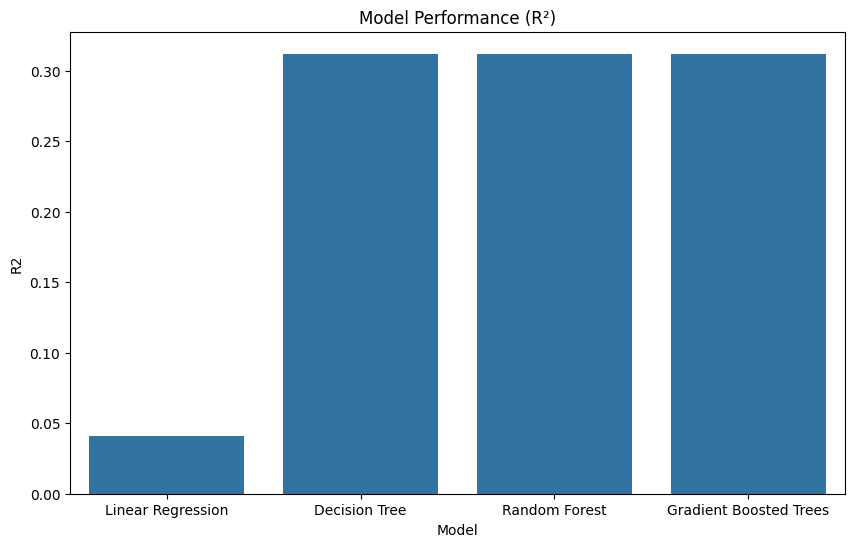

In [12]:
# Display the results
for result in results:
    print(f"Model: {result['Model']}, R²: {result['R2']:.4f}, RMSE: {result['RMSE']:.4f}")

# Visualize the results
df_results = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2', data=df_results)
plt.title('Model Performance (R²)')
plt.show()

# Stop Spark session
spark.stop()

1. **Menampilkan hasil evaluasi model:**
   ```python
   for result in results:
       print(f"Model: {result['Model']}, R²: {result['R2']:.4f}, RMSE: {result['RMSE']:.4f}")
   ```
   - Loop ini melalui setiap item dalam daftar `results` yang berisi hasil evaluasi model.
   - Format hasil ditampilkan dengan model, nilai R², dan RMSE, di mana `.4f` berarti hasil akan ditampilkan hingga 4 angka desimal.
   - Hasil ini memberikan gambaran kinerja setiap model berdasarkan dua metrik utama: **R²** dan **RMSE**.

2. **Memvisualisasikan hasil dengan grafik batang:**
   ```python
   df_results = pd.DataFrame(results)
   plt.figure(figsize=(10, 6))
   sns.barplot(x='Model', y='R2', data=df_results)
   plt.title('Model Performance (R²)')
   plt.show()
   ```
   - **`df_results = pd.DataFrame(results)`**: Hasil evaluasi yang disimpan dalam `results` dikonversi menjadi DataFrame pandas agar mudah divisualisasikan.
   - **`plt.figure(figsize=(10, 6))`**: Membuat sebuah *figure* atau kanvas untuk grafik dengan ukuran 10x6 inci.
   - **`sns.barplot()`**: Menggunakan *seaborn* untuk membuat grafik batang (*bar plot*), dengan model di sumbu-x dan nilai **R²** di sumbu-y.
   - **`plt.title('Model Performance (R²)')`**: Menambahkan judul pada grafik yang menunjukkan bahwa grafik ini menampilkan kinerja model berdasarkan R².
   - **`plt.show()`**: Menampilkan grafik.

   **Tujuan:** Memvisualisasikan nilai R² untuk setiap model dalam bentuk grafik batang agar memudahkan perbandingan kinerja model secara visual.

3. **Menghentikan sesi Spark:**
   ```python
   spark.stop()
   ```
   - **`spark.stop()`** digunakan untuk menghentikan sesi Spark setelah semua proses selesai. Ini adalah praktik yang baik untuk membebaskan sumber daya yang digunakan oleh Spark setelah proses selesai.

   **Tujuan:** Mengakhiri sesi Spark dengan benar setelah pemrosesan selesai.

Hasil evaluasi dari beberapa model regresi menunjukkan performa dalam memprediksi harga kendaraan:

1. **Linear Regression**:
   - **R²: 0.0409**: Nilai ini sangat rendah, yang berarti model hanya mampu menjelaskan sekitar 4% dari variabilitas data. Model ini tidak cocok untuk prediksi yang baik dalam kasus ini.
   - **RMSE: 14,686.6231**: Nilai error ini cukup tinggi, menunjukkan bahwa prediksi harga yang dihasilkan memiliki selisih yang besar dari nilai aktualnya.

2. **Decision Tree**:
   - **R²: 0.3115**: Ini menunjukkan bahwa model decision tree bisa menjelaskan sekitar 31% variabilitas dalam data, lebih baik dibanding regresi linear, tapi masih jauh dari optimal.
   - **RMSE: 12,443.9140**: Nilai error lebih rendah dari model regresi linear, menunjukkan prediksi yang lebih baik.

3. **Random Forest**:
   - **R²: 0.3114**: Hampir sama dengan decision tree, menandakan bahwa performanya sebanding.
   - **RMSE: 12,444.0729**: Nilai RMSE juga sangat mirip dengan decision tree, yang menunjukkan bahwa model ini tidak terlalu jauh berbeda dalam hasilnya.

4. **Gradient Boosted Trees (GBT)**:
   - **R²: 0.3119**: Sedikit lebih baik daripada decision tree dan random forest, tapi peningkatannya kecil.
   - **RMSE: 12,439.8069**: Nilai RMSE sedikit lebih rendah dari kedua model sebelumnya, menunjukkan prediksi yang sedikit lebih akurat.

**Kesimpulan:**
- Semua model berbasis pohon (Decision Tree, Random Forest, GBT) memiliki performa yang jauh lebih baik dibandingkan regresi linear dalam hal nilai R² dan RMSE.
- Gradient Boosted Trees sedikit unggul dalam akurasi, meskipun perbedaan dengan model Decision Tree dan Random Forest tidak terlalu signifikan.
- Namun, R² sekitar 0.31 masih menunjukkan bahwa model hanya mampu menjelaskan sekitar 31% dari variasi harga kendaraan, jadi ada kemungkinan data tambahan atau fitur lain dibutuhkan untuk meningkatkan performa model secara keseluruhan.